In [ ]:
# importing libraries

from PIL import Image, ImageDraw, ImageFilter
import requests
from io import BytesIO
import matplotlib.pyplot as plt
import numpy as np
import random
import math
import copy
import time
from scipy.stats import mode

%matplotlib inline

In [ ]:
# defining constants

NUMBER = 20
POPULATION_SIZE = 10
IM_SIZE = (512, 512)
BLACK = (0, 0, 0, 255)
WHITE = (255, 255, 255, 255)
RED = (255, 0, 0, 255)
GREEN = (0, 255, 0, 255)
BLUE = (0, 0, 255, 255)
COLORS = 8

In [ ]:
def rgb_to_hsv(r, g, b):
    '''
    Converts the RGB colour representation into the HSV
    Args:
        r, g, b (int): colour values for red, green and blue, from 0 to 255
    Returns:
        h (int): value for hue, from 0 to 360
        s, v (int): values for saturation and value, from 0 to 100
    '''
    r, g, b = r/255.0, g/255.0, b/255.0
    mx = max(r, g, b)
    mn = min(r, g, b)
    df = mx-mn
    if mx == mn:
        h = 0
    elif mx == r:
        h = (60 * ((g-b)/df) + 360) % 360
    elif mx == g:
        h = (60 * ((b-r)/df) + 120) % 360
    elif mx == b:
        h = (60 * ((r-g)/df) + 240) % 360
    if mx == 0:
        s = 0
    else:
        s = (df/mx)*100
    v = mx*100
    return h, s, v


def hsv_to_rgb(h, s, v):
    '''
    Converts the RGB colour representation into the HSV
    Args:
        h (int): value for hue, from 0 to 360
        s, v (int): values for saturation and value, from 0 to 100
    Returns:
        r, g, b (int): colour values for red, green and blue, from 0 to 255
    '''
    h = float(h) / 360
    s = float(s) / 100
    v = float(v) / 100
    if s == 0.0: v*=255; return (v, v, v)
    i = int(h*6.)
    f = (h*6.)-i; p,q,t = int(255*(v*(1.-s))), int(255*(v*(1.-s*f))), int(255*(v*(1.-s*(1.-f)))); v*=255; i%=6
    if i == 0: return (v, t, p)
    if i == 1: return (q, v, p)
    if i == 2: return (p, v, t)
    if i == 3: return (p, q, v)
    if i == 4: return (t, p, v)
    if i == 5: return (v, p, q)


def warholize(np_img):
    '''
    Converts the image into the so-called warholized form: adds to the original one 3 copies with the shifted hue values
    Args:
        np_img (numpy array): an array representing the original image, colours are encoded in RGB format
    Returns:
        res_img (numpy array): an array representing the warholized image, colours are encoded in RGB format
    '''
    vert_space = math.ceil(np_img.shape[0] * 0.025)
    hor_space = math.ceil(np_img.shape[1] * 0.025)
    # creating 4 separate images
    hsv_img1 = np.full((np_img.shape[0] + 3 * vert_space, np_img.shape[1] + 3 * hor_space, 3), 255)
    hsv_img2 = np.full((np_img.shape[0] + 3 * vert_space, np_img.shape[1] + 3 * hor_space, 3), 255)
    hsv_img3 = np.full((np_img.shape[0] + 3 * vert_space, np_img.shape[1] + 3 * hor_space, 3), 255)
    hsv_img4 = np.full((np_img.shape[0] + 3 * vert_space, np_img.shape[1] + 3 * hor_space, 3), 255)
    # shifting hue values for each pixel, saving results in corresponding arrays
    # shift values are 60, 200 and 320
    for i in range(np_img.shape[0]):
        for j in range(np_img.shape[1]):
            col = rgb_to_hsv(np_img[i][j][0], np_img[i][j][1], np_img[i][j][2])
            sec_col = 0
            third_col = 0
            fourth_col = 0
            if col[0] + 200 < 360:
                sec_col = col[0] + 200
            else:
                sec_col = col[0] + 200 - 360
            if col[0] + 60 < 360:
                third_col = col[0] + 60
            else:
                third_col = col[0] + 60 - 360
            if col[0] + 320 < 360:
                fourth_col = col[0] + 320
            else:
                fourth_col = col[0] + 320 - 360
            first = hsv_to_rgb(col[0], col[1], col[2])
            second = hsv_to_rgb(sec_col, col[1], col[2])
            third = hsv_to_rgb(third_col, col[1], col[2])
            fourth = hsv_to_rgb(fourth_col, col[1], col[2])
            hsv_img1[i + 2 * vert_space][j + 2 * hor_space] = [first[0], first[1], first[2]]
            hsv_img3[i + 2 * vert_space][j + hor_space] = [second[0], second[1], second[2]]
            hsv_img2[i + vert_space][j + 2 * hor_space] = [third[0], third[1], third[2]]
            hsv_img4[i + vert_space][j + hor_space] = [fourth[0], fourth[1], fourth[2]]
    # combining the images together
    res_img1 = np.concatenate((hsv_img1, hsv_img2), axis=0)
    res_img2 = np.concatenate((hsv_img3, hsv_img4), axis=0)
    res_img = np.concatenate((res_img1, res_img2), axis=1)
    res_img = res_img.astype(int)

    return res_img

In [ ]:
def rand_palette_colour(palette):
    '''
    Chooses the random colour from the given palette
    Args:
        palette (array-like): the array storing the colours
    Returns:
        palette[rand_ind] (array-like): a random colour picked from the palette
    '''
    rand_ind = random.randint(0, len(palette) - 1)
    return palette[rand_ind]

In [ ]:
def generate_img(img, x, y, z):
    '''
    Generates the best possible image that may be produced out of img with x squares of size z in the height, y in the width
    Args:
        img (numpy array): an array representing the image, colours are stored in RGB format
        x (int): number of squares on the vertical
        y (int): number of squares on the horizontal
        z (int): a size of a square side
    Returns:
        new (numpy array): an array representing the best image possible, colours are stored in RGB format
    '''
    new = np.zeros((x, y, 3))
    i_prev = 0
    j_prev = 0
    for i in range(z, x*z, z):
        for j in range(z, y*z, z):
            x0 = i_prev
            x1 = min(i, img.shape[0])
            y0 = j_prev
            y1 = min(j, img.shape[1])
            cols = dict()
            # determining the counts for each colour used in a given square, finding the most common ones
            if x0 < x1 and y0 < y1:
                for x_coord in range(x0, x1):
                    for y_coord in range(y0, y1):
                        col = str(img[x_coord, y_coord, 0]) + ' ' + str(img[x_coord, y_coord, 1]) + ' ' + str(img[x_coord, y_coord, 2])
                        if col in cols.keys():
                            cols[col] += 1
                        else:
                            cols[col] = 1
                cols_sorted = sorted(cols.items(), key=lambda item: item[1])[-1][0].split(' ')
                new[i//z-1, j//z-1, 0] = int(cols_sorted[0])
                new[i//z-1, j//z-1, 1] = int(cols_sorted[1])
                new[i//z-1, j//z-1, 2] = int(cols_sorted[2])
            j_prev = j
        j_prev = 0
        i_prev = i
    new = new.astype(int)
    return new


def generate_square(size, coord, palette):
    '''
    Generates a square located at given coordinates with a random colour from the palette
    Args:
        size (int): a length of a square side
        coord (tuple): the x,y coordinates of the upper-left corner of a square
        palette (array-like): an array of colours possible
    Returns:
        square (Square): a new object of a Square class
    '''
    v1 = coord
    v2 = (coord[0] + size, coord[1])
    v3 = (coord[0] + size, coord[1] + size)
    v4 = (coord[0], coord[1] + size)
    return Square([v1, v2, v3, v4], rand_palette_colour(palette))


def generate_row(num, begin_coord, size, palette):
    '''
    Generates a row of squares
    Args:
        num (int): a number of squares in one row
        begin_coord (tuple): the x,y coordinates of the row beginning
        size (int): a length of a square side
        palette (array-like): an array of colours
    Returns:
        row (array-like): an array of Square objects
    '''
    row = []
    coord = begin_coord
    for i in range(num):
        row.append(generate_square(size, coord, palette))
        coord = (coord[0] + size, coord[1])
    return row


def generate_dna(img, palette, size, num_in_col, num_in_row, img_size):
    '''
    Generates a DNA representing the given image
    Args:
        img (numpy array): an image to be generated
        palette (array-like): an array of colours
        size (int): a length of a square side
        num_in_col (int): a number of squares in one column
        num_in_row (int): a number of squares in one row
    Returns:
        dna (DNA): an object of class DNA
    '''
    seq = []
    coord = (0, 0)
    for i in range(num_in_col):
        seq = seq + generate_row(num_in_row, coord, size, palette)
        coord = (0, coord[1] + size)
    return DNA(seq, palette, img, img_size)


def generate_population(img, palette, pop_size=POPULATION_SIZE, num_in_row=NUMBER):
    '''
    Generates a population representing the given image
    Args:
        img (numpy array): an image to be generated
        palette (array-like): an array of colours
        pop_size (int): a size of a population
        num_in_row (int): a number of squares in one row
    Returns:
        population (Population): an object of class Population
    '''
    img_size = (img.shape[0], img.shape[1])
    print(img_size)
    size = math.ceil(float(img_size[1]) / num_in_row)
    num_in_col = math.ceil(img_size[0] / size)
    pop = []
    best_img = generate_img(img, num_in_col, num_in_row, size)
    print(num_in_col, num_in_row)
    for i in range(pop_size):
        pop.append(generate_dna(img, palette, size, num_in_col, num_in_row, img_size))
    return Population(pop, palette, best_img, img_size)

In [ ]:
class Square:

    def __init__(self, vertices, colour):
        self.vertices = vertices
        self.colour = colour

    def mutate(self, palette):
        # randomly changes colour
        self.colour = rand_palette_colour(palette)

    def error(self, img):
        # calculates the error between the colour of a square and of desired colour
        size = self.vertices[1][0] - self.vertices[0][0]
        x_coord = self.vertices[0][1] // size
        y_coord = self.vertices[0][0] // size
        err = (((img[x_coord][y_coord][0] - self.colour[0]) / 255)**2 + ((img[x_coord][y_coord][1] - self.colour[1]) / 255)**2 + ((img[x_coord][y_coord][2] - self.colour[2]) / 255)**2)**0.5
        
        return err

In [ ]:
class DNA:

    def __init__(self, sequence, palette, img, img_size=IM_SIZE):
        self.image = img
        self.img_size = img_size
        self.sequence = sequence
        self.palette = palette

    def draw(self, bckgrnd=WHITE, show=False, save=False, name='default_name'):
        # creates an image encoded inside the DNA
        if len(self.sequence) < 1:
            print('DNA was not created yet')
        else:
            img = Image.new('RGB', (self.img_size[1], self.img_size[0]), bckgrnd)
            draw = Image.new('RGBA', (self.img_size[1], self.img_size[0]))
            polydraw = ImageDraw.Draw(draw)
            for p in self.sequence:
                colour = p.colour
                points = p.vertices
                polydraw.polygon(points, fill=colour, outline=colour)
                img.paste(draw, mask=draw)
            if save:
                img.save(name + '.png')
            if show:
                img.show()
            return img

    def calculate_error(self):
        # calculaates the DNA error as a sum of errors of all of its squares
        error = 0
        for i in self.sequence:
            error += i.error(self.image)
        return error

    def mutate(self, mut_percent=1):
        # mutation is performed on the mut_percent of least suitable squares
        if len(self.sequence) < 1:
            print('DNA was not created yet')
        else:
            size = len(self.sequence)
            ind_err = []
            total = 0.0
            # calculating errors
            num = math.ceil(size * mut_percent * 0.01)
            if num < 1:
                num = 1
            for i in range(num):
                rand_ind = random.randint(0, size-1)
                t_square = copy.deepcopy(self.sequence[rand_ind])
                prev_err = t_square.error(self.image)
                t_square.mutate(self.palette)
                err = t_square.error(self.image)
                if err < prev_err:
                    self.sequence[rand_ind] = t_square

In [ ]:
class Population:
    def __init__(self, organisms, palette, img, img_size=IM_SIZE):
        self.organisms = organisms
        self.palette = palette
        self.image = img
        self.img_size = img_size

    def select(self, k=5):
        # the tournament selection is performed
        size = len(self.organisms)
        new_org = []
        for i in range(size):
            rand_ind = [random.randint(0, size-1) for i in range(k)]
            best_org = self.organisms[rand_ind[0]]
            best_fit = self.organisms[rand_ind[0]].calculate_error()
            for j in range(1, k):
                err = self.organisms[rand_ind[j]].calculate_error()
                if err < best_fit:
                    best_fit = err
                    best_org = self.organisms[rand_ind[j]]
            new_org.append(best_org)
        self.organisms = new_org

    def mutate(self, mut_percent=1):
        rand_num = random.randint(0, len(self.organisms) - 1)
        self.organisms[rand_num].mutate(mut_percent)

    def crossover(self, rate=0.2):
        # one-point crossover
        cross_chrom_ind = []
        for i in range(len(self.organisms)):
            cross_rand = random.random()
            if cross_rand < 0.2:
                cross_chrom_ind.append(i)
        size = len(cross_chrom_ind)
        if size == 1:
            return self
        else:
            new_org = copy.deepcopy(self.organisms)
            for ind in cross_chrom_ind:
                ind2_idx = random.randint(0, size - 1)
                ind2 = cross_chrom_ind[ind2_idx]
                if ind2 == ind:
                    if ind2_idx != 0:
                        ind2 = cross_chrom_ind[ind2_idx - 1]
                    else:
                        ind2 = cross_chrom_ind[size - 1]
                cross_point = random.randint(0, len(self.organisms) - 1)
                new_org[ind] = DNA(new_org[ind].sequence[:cross_point] + new_org[ind2].sequence[cross_point:], self.palette, self.image, self.img_size)
            self.organisms = new_org

    def best_fit(self):
        # returns the DNA from the population with the least error
        min_err = self.organisms[0].calculate_error()
        organism = self.organisms[0]
        for i in range(1, len(self.organisms)):
            err = self.organisms[i].calculate_error()
            if err < min_err:
                min_err = err
                organism = self.organisms[i]
        return organism, min_err

In [ ]:
def process_image(img, colour_num=15):
    '''
    Converts the image to the one with the restricted number of colours
    Args:
        img (numpy array): an array representing the original image
        colour_num (int): the number of colours used in the resulting image
    Returns:
        np_img (numpy array): the transformed image
        palette (array-like): the array of colours used
    '''
    im_for_pal = img.convert('P', palette=Image.ADAPTIVE, colors=colour_num)
    im_palette = im_for_pal.getpalette()
    rgb_im = im_for_pal.convert('RGB')
    np_img = np.asarray(rgb_im)

    palette = []
    for i in range(colour_num):
        col = (im_palette[i*3], im_palette[i*3 + 1], im_palette[i*3 + 2], 255)
        palette.append(col)
    palette = list(set(palette))

    return np_img, palette


def create_image(img, palette, pop_size=10, num_in_row=100):
    '''
    Generates the image using the genetic algorithm
    Args:
        img (numpy array): the best image that can be obtained
        palette (array-like): the array of colours used in the image
        pop_size (int): the number of individuals in the generation
        num_in_row (int): the number of square on the image row
    Returns:
        res (Population): an object of a class Population, the generation obtained during the last iteration performed
    '''
    start_time = time.time()
    population = generate_population(img=img, palette=palette, pop_size=pop_size, num_in_row=num_in_row)
    _, initial_err = population.best_fit()
    max_err = 3 * num_in_row * (img.shape[0] / (img.shape[1] / num_in_row))
    print(max_err)

    eps = 3
    i = 0
    percent = 20
    prev_prev_err = max_err
    prev_err = initial_err
    start_again = False
    while True:
        if i == 300:
            start_again = True
            return population
            break
        if i % 10 == 0:
            t_img = population.organisms[0].draw()
            name = 'cat_' + str(i) + '.png'
            t_img.save(name)
        if i % 5 == 0:
            _, err = population.best_fit()
            if abs(err - prev_err) < eps and abs(prev_err - prev_prev_err) < eps and i != 0:
                start_again = True
                print('reached local minimum')
                return population
                break
            if err < max_err * 0.003:
                break
            if err / max_err < 0.3:
                percent = 15
            if err / max_err < 0.1:
                percent = 10
            if err / max_err < 0.02:
                percent = 5
            if err / max_err < 0.01:
                percent = 1
            print('error: {}'.format(err))
            print('done ' + str(i))
            print()
            prev_prev_err = prev_err
            prev_err = err
        #population.select()
        population.crossover()
        num_to_mutate = random.randint(0, 5)
        for j in range(num_to_mutate):
            population.mutate(percent)
        i += 1
    if not start_again:
        res = population
        print("--- %s seconds ---" % (time.time() - start_time))
        return res

In [ ]:
# retrieving an image
link_to_img = 'https://sun9-35.userapi.com/c855616/v855616531/22e6d9/wTCrgE7ZlCk.jpg'
response = requests.get(link_to_img)
img = Image.open(BytesIO(response.content))
print(img.size)
# uncomment if an image is greater than 512x512
img.thumbnail((400, 400))

# retrieving the palette and the image with a restricted number of colours used
colours_num = 20
new_img, palette = process_image(img, colours_num)

(512, 512)


In [ ]:
# generating the image
result = create_image(new_img, palette, 5, 200)

(400, 400)
200 200
120000.0
error: 17483.19126240637
done 0

error: 14015.871524696206
done 5

error: 12917.577045217413
done 10

error: 12246.831816443042
done 15

error: 11430.34938791408
done 20

error: 11069.998644673027
done 25

error: 10597.811902211391
done 30

error: 10368.960553332361
done 35

error: 9835.899054076872
done 40

error: 9084.659725293768
done 45

error: 8716.388175947379
done 50

error: 8268.069415585745
done 55

error: 8145.362670620827
done 60

error: 8007.415353910196
done 65

error: 9074.974455898679
done 70

error: 8472.50623808898
done 75

error: 8169.063746087137
done 80

error: 7553.509857981699
done 85

error: 7152.776309659013
done 90

error: 6855.738503141276
done 95

error: 6278.855451365556
done 100

error: 6044.444375115092
done 105

error: 6488.9480427726485
done 110

error: 6331.226806501001
done 115

error: 6176.973990380502
done 120

error: 5781.650400920616
done 125

error: 5641.330131011139
done 130

error: 5402.246315916433
done 135

error: 5

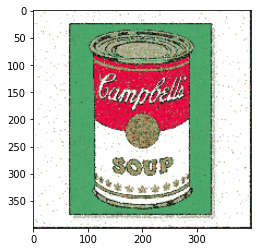

In [ ]:
# getting the generated image
best, err = result.best_fit()
best_img = best.draw()
best_img_np = np.asarray(best_img)

# uncomment for showing the image
plt.imshow(best_img_np)

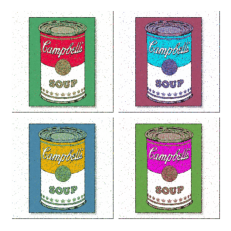

In [ ]:
# making something weird from the image
warh = warholize(best_img_np)

# uncomment for showing
plt.imshow(warh)
plt.axis('off')
plt.savefig('warh_cat.png', bbox_inches='tight')